## Proof-of-concept implementation of the oriented rectangular hull method from [1]

[1] Stursberg, O., & Krogh, B. H. (2003, April). Efficient representation and computation of reachable sets for hybrid systems. In International Workshop on Hybrid Systems: Computation and Control (pp. 482-497). Springer, Berlin, Heidelberg.

In [1]:
using LazySets, LinearAlgebra, Plots

In [2]:
X = [rand(Singleton) for _ in 1:50]
CX = ConvexHullArray(X)
BX = overapproximate(CX, Hyperrectangle);

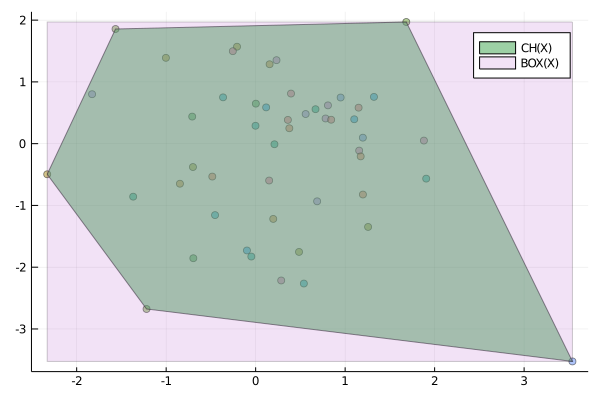

In [3]:
plot(X)
plot!(CX, lab="CH(X)")
plot!(BX, lab="BOX(X)", alpha=.2)

In [4]:
xmean = sum([element(x) for x in X]) / length(X)

2-element Array{Float64,1}:
  0.2638703199296403
 -0.1354913355000029

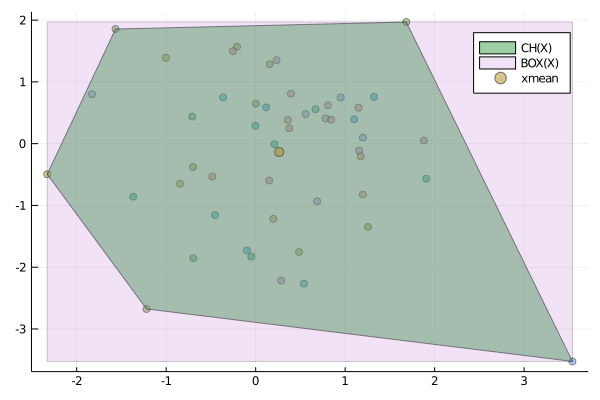

In [5]:
plot!(Singleton(xmean), lab="xmean", markersize=5.0)

In [6]:
Xmat = hcat([element(x) for x in X]...) # singleton's matrix

2×50 Array{Float64,2}:
 1.32195   0.376332  0.00210769  0.233003  …  -1.21925  -0.097301   1.17378
 0.757175  0.249085  0.647563    1.35154      -2.67668  -1.72914   -0.206156

In [7]:
X̄mat = Xmat .- xmean # translated matrix

2×50 Array{Float64,2}:
 1.05808   0.112462  -0.261763  …  -1.48312  -0.361171   0.90991
 0.892666  0.384577   0.783054     -2.54119  -1.59365   -0.0706651

In [8]:
X̄cov = (X̄mat * X̄mat')/(length(X)-1)

2×2 Array{Float64,2}:
  1.10851   -0.154117
 -0.154117   1.50491

In [9]:
U, Σ, _ = svd(X̄cov)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
2×2 Array{Float64,2}:
 -0.324475  0.945894
  0.945894  0.324475
singular values:
2-element Array{Float64,1}:
 1.5577822800821153
 1.0556403843298208
Vt factor:
2×2 Array{Float64,2}:
 -0.324475  0.945894
  0.945894  0.324475

In [10]:
α = maximum(dot(U[:, 1], X̄mat[:, i]) for i in 1:length(X))
β = dot(U[:, 1], xmean)
H1₊ = HalfSpace(U[:, 1], α + β)

α = minimum(dot(U[:, 1], X̄mat[:, i]) for i in 1:length(X))
β = dot(U[:, 1], xmean)
H1₋ = HalfSpace(-U[:, 1], -α - β)

HalfSpace{Float64,Array{Float64,1}}([0.32447454369001144, -0.9458944288329216], 4.483556647063451)

In [11]:
α = maximum(dot(U[:, 2], X̄mat[:, i]) for i in 1:length(X))
β = dot(U[:, 2], xmean)
H2₊ = HalfSpace(U[:, 2], α + β)

α = minimum(dot(U[:, 2], X̄mat[:, i]) for i in 1:length(X))
β = dot(U[:, 2], xmean)
H2₋ = HalfSpace(-U[:, 2], -α - β)

HalfSpace{Float64,Array{Float64,1}}([-0.9458944288329216, -0.32447454369001144], 2.3640766990032693)

In [12]:
P = HPolyhedron([H1₊, H1₋, H2₊, H2₋])

HPolyhedron{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-0.32447454369001144, 0.9458944288329216], 2.263996675688606), HalfSpace{Float64,Array{Float64,1}}([0.32447454369001144, -0.9458944288329216], 4.483556647063451), HalfSpace{Float64,Array{Float64,1}}([0.9458944288329216, 0.32447454369001144], 2.231397081707235), HalfSpace{Float64,Array{Float64,1}}([-0.9458944288329216, -0.32447454369001144], 2.3640766990032693)])

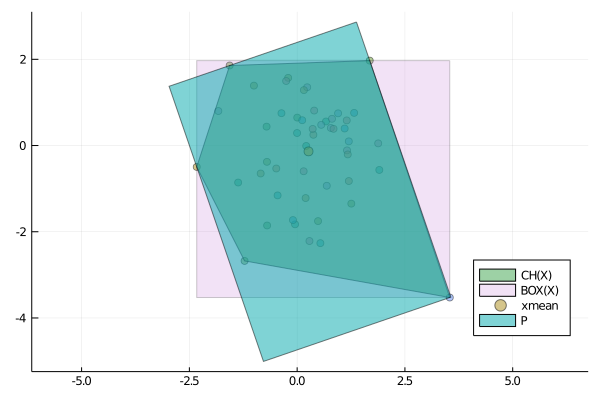

In [13]:
plot!(P, lab="P", ratio=1, legend=:bottomright)

In [14]:
maximum(transpose(U) * X̄mat, dims=2) + transpose(U) * xmean

2×1 Array{Float64,2}:
 2.263996675688606
 2.231397081707235

## Implementation

In [18]:
function oriented_rectangular_hull(X::Vector{<:AbstractSingleton{N}}) where {N}
    p = length(X)
    n = dim(first(X))
    
    # compute mean point
    xmean = zeros(N, n)
    for x in X
        xmean += element(x)
    end
    xmean .= xmean / p
    
    # compute covariance matrix
    X̄mat = Matrix{N}(undef, n, p)
    @inbounds for (j, x) in enumerate(X) 
        X̄mat[:, j] = element(x) - xmean
    end
    X̄cov = (X̄mat * X̄mat')/(p-1)

    # compute singular value decomposition of the covariance matrix
    U, Σ, _ = svd(X̄cov)

    # weights
    Uᵀ = transpose(U)
    T = Uᵀ * X̄mat
    ν = Uᵀ * xmean
    W₊ = maximum(T, dims=2) + ν
    W₋ = -minimum(T, dims=2) - ν

    # build polytpe constrained by the columns of U
    constraints = Vector{HalfSpace{N, Vector{N}}}(undef, 2n)
    j = 1
    @inbounds for i in 1:n
        constraints[j] = HalfSpace(U[:, i], W₊[i])
        constraints[j+1] = HalfSpace(-U[:, i], W₋[i])
        j += 2
    end
    return HPolytope(constraints)
end

function oriented_rectangular_hull(X::UnionSetArray{N, <:AbstractSingleton{N}}) where {N}
    return oriented_rectangular_hull(array(X))
end

oriented_rectangular_hull (generic function with 2 methods)

In [19]:
X = [rand(Singleton, dim=2) for _ in 1:50] |> UnionSetArray;
B = oriented_rectangular_hull(X)

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([0.20032605316421187, 0.9797292852740747], 2.336499041812915), HalfSpace{Float64,Array{Float64,1}}([-0.20032605316421187, -0.9797292852740747], 2.538391418243874), HalfSpace{Float64,Array{Float64,1}}([0.9797292852740745, -0.20032605316421184], 2.1501255727551625), HalfSpace{Float64,Array{Float64,1}}([-0.9797292852740745, 0.20032605316421184], 1.99983505578307)])

In [20]:
using BenchmarkTools

In [24]:
X = [rand(Singleton) for _ in 1:50]
@btime oriented_rectangular_hull($X)

X = [rand(Singleton) for _ in 1:1000]
@btime oriented_rectangular_hull($X)

  9.194 μs (151 allocations: 14.59 KiB)
  100.071 μs (2051 allocations: 222.47 KiB)


HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-0.9887665813085345, 0.1494678817921554], 2.959996967667704), HalfSpace{Float64,Array{Float64,1}}([0.9887665813085345, -0.1494678817921554], 3.158601705956333), HalfSpace{Float64,Array{Float64,1}}([0.14946788179215542, 0.9887665813085343], 3.2931371063469563), HalfSpace{Float64,Array{Float64,1}}([-0.14946788179215542, -0.9887665813085343], 3.3160230697133177)])

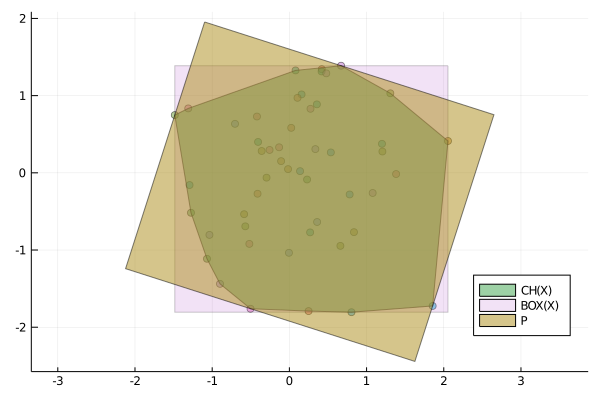

In [22]:
X = [rand(Singleton) for _ in 1:50]
CX = ConvexHullArray(X)
BX = overapproximate(CX, Hyperrectangle);
P = oriented_rectangular_hull(X)

plot(X)
plot!(CX, lab="CH(X)")
plot!(BX, lab="BOX(X)", alpha=.2)
plot!(P, lab="P", ratio=1, legend=:bottomright)

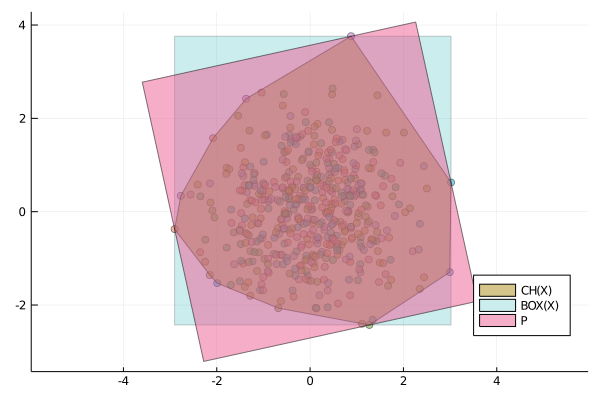

In [27]:
X = [rand(Singleton) for _ in 1:500]
CX = ConvexHullArray(X)
BX = overapproximate(CX, Hyperrectangle);
P = oriented_rectangular_hull(X)

plot(X)
plot!(CX, lab="CH(X)")
plot!(BX, lab="BOX(X)", alpha=.2)
plot!(P, lab="P", ratio=1, legend=:bottomright)

## Higher dimensions

We observe that in higher dimensions the obtained set does not tightly enclose the point set.

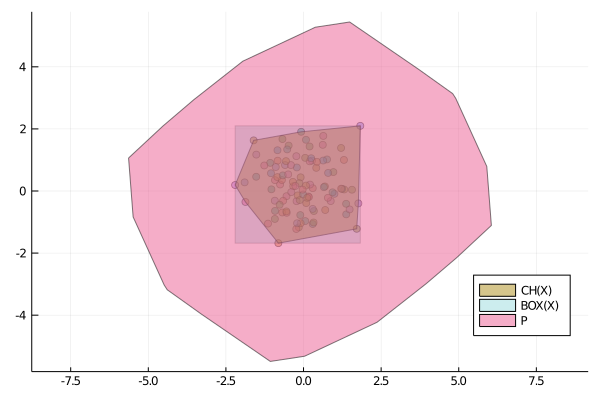

In [46]:
X = [rand(Singleton, dim=10) for _ in 1:100] 
CX = ConvexHullArray(X)
BX = overapproximate(CX, Hyperrectangle);
P = oriented_rectangular_hull(X)

#plot(Projection(UnionSetArray(X), [1, 2]))
plot([project(x, [1, 2]) for x in X])
plot!(Projection(CX, [1, 2]), lab="CH(X)")
plot!(Projection(BX, [1, 2]), lab="BOX(X)", alpha=.2)
plot!(Projection(P, [1, 2]), lab="P", ratio=1, legend=:bottomright)

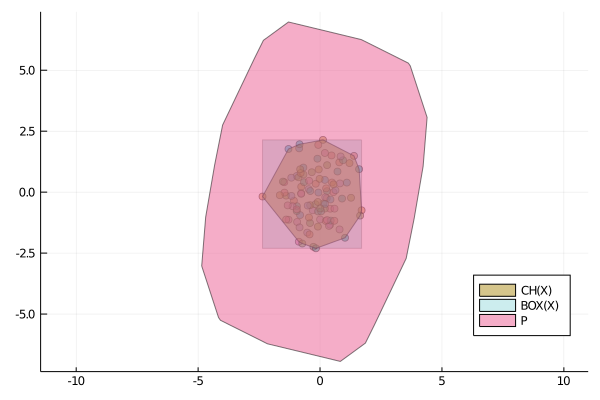

In [53]:
plot([project(x, [9, 10]) for x in X])
plot!(Projection(CX, [9, 10]), lab="CH(X)")
plot!(Projection(BX, [9, 10]), lab="BOX(X)", alpha=.2)
plot!(Projection(P, [9, 10]), lab="P", ratio=1, legend=:bottomright)